# DQN with tensorflow


### Referrence 
https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

### Environment setting 

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common


import abc

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

C:\Users\ksko\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# tf.compat.v1.enable_v2_behavior()
# # Set up a virtual display for ren|dering OpenAI gym environments.
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [4]:
tf.version.VERSION

'2.9.0'

### 하이퍼파라메터 설정 

In [5]:
num_iterations = 2000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

### 환경

***수직선이동***

(1) S=[0,3].

(2) A=[-1,1]. 

(3) reward=-(CurrentState - 2.33)**2

In [6]:
class LinegameEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=1000, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, name='observation')
        self._state = 0
        self._time = 1
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = 0
        self._time = 1
        self._episode_ended = False
        return ts.restart(np.array([self._state], dtype=np.int32))

    def _step(self, action):
        if self._episode_ended:
            self.reset()
        elif self._time==1: 
            print("### new episode start! ###")
            print(" ")
        else: 
            print(" ")
        
        print("{}-1. current state = {}".format(self._time,self._state))
        
        reward = -(self._state-2.33)**2
        
        self._state += (action-500)/500
        print("{}-2. action = {}".format(self._time,(action-500)/500))
        if self._state < 0:
          print("    **exit(current state<0) => reset current state as 0.**")
          self._state = 0
        if self._state > 3 : 
          print("   **exit(current state >3) => reset current state as 3.**")
          self._state = 3
        
        print("{}-3. reward = {}".format(self._time,reward))
        print("{}-4. future state = {}".format(self._time,self._state))
        
        self._time += 1
        if self._time > 7: self._episode_ended = True
        
        if self._episode_ended:
            print(" ")
            print("### episode ended ###")
            return ts.termination(np.array([self._state], dtype=np.int32), reward)
        else:
            return ts.transition(np.array([self._state], dtype=np.int32), reward=0.0, discount=1.0)

In [7]:
environment = LinegameEnv()
utils.validate_py_environment(environment, episodes=2)

### new episode start! ###
 
1-1. current state = 0
1-2. action = -0.446
    **exit(current state<0) => reset current state as 0.**
1-3. reward = -5.4289000000000005
1-4. future state = 0
 
2-1. current state = 0
2-2. action = 0.198
2-3. reward = -5.4289000000000005
2-4. future state = 0.198
 
3-1. current state = 0.198
3-2. action = 0.56
3-3. reward = -4.545424000000001
3-4. future state = 0.758
 
4-1. current state = 0.758
4-2. action = -0.248
4-3. reward = -2.471184
4-4. future state = 0.51
 
5-1. current state = 0.51
5-2. action = -0.758
    **exit(current state<0) => reset current state as 0.**
5-3. reward = -3.3124000000000002
5-4. future state = 0
 
6-1. current state = 0
6-2. action = -0.27
    **exit(current state<0) => reset current state as 0.**
6-3. reward = -5.4289000000000005
6-4. future state = 0
 
7-1. current state = 0
7-2. action = -0.148
    **exit(current state<0) => reset current state as 0.**
7-3. reward = -5.4289000000000005
7-4. future state = 0
 
### episode en

In [11]:
train_py_env = LinegameEnv
eval_py_env = LinegameEnv
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### 에이전트

In [12]:
fc_layer_params = (100,)
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)
agent.initialize()

### Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

In this tutorial:

-   The desired outcome is keeping the pole balanced upright over the cart.
-   The policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [9]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [18]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

### Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [15]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [12]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

### new episode start! ###
 
1-1. current state = 0
1-2. action = -0.248
    **exit(current state<0) => reset current state as 0.**
1-3. reward = -5.4289000000000005
1-4. future state = 0
 
2-1. current state = 0
2-2. action = 0.9
2-3. reward = -5.4289000000000005
2-4. future state = 0.9
 
3-1. current state = 0.9
3-2. action = -0.93
    **exit(current state<0) => reset current state as 0.**
3-3. reward = -2.0449000000000006
3-4. future state = 0
 
4-1. current state = 0
4-2. action = -0.05
    **exit(current state<0) => reset current state as 0.**
4-3. reward = -5.4289000000000005
4-4. future state = 0
 
5-1. current state = 0
5-2. action = 0.232
5-3. reward = -5.4289000000000005
5-4. future state = 0.232
 
6-1. current state = 0.232
6-2. action = -0.066
6-3. reward = -4.401604
6-4. future state = 0.166
 
7-1. current state = 0.166
7-2. action = -0.136
7-3. reward = -4.682896
7-4. future state = 0.03
 
### episode ended ###
### new episode start! ###
 
1-1. current state = 0
1-2. acti

-3.6567187

### Replay Buffer

The replay buffer keeps track of data collected from the environment. This tutorial uses `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, as it is the most common. 

The constructor requires the specs for the data it will be collecting. This is available from the agent using the `collect_data_spec` method. The batch size and maximum buffer length are also required.


In [20]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [21]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0), maximum=array(1000)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(1,), dtype=tf.int32, name='observation', minimum=array(0), maximum=array(2147483647)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [22]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

### Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [23]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

### new episode start! ###
 
1-1. current state = 0
1-2. action = -0.448
    **exit(current state<0) => reset current state as 0.**
1-3. reward = -5.4289000000000005
1-4. future state = 0
 
2-1. current state = 0
2-2. action = 0.488
2-3. reward = -5.4289000000000005
2-4. future state = 0.488
 
3-1. current state = 0.488
3-2. action = 0.986
3-3. reward = -3.392964
3-4. future state = 1.474
 
4-1. current state = 1.474
4-2. action = 0.106
4-3. reward = -0.7327360000000002
4-4. future state = 1.58
 
5-1. current state = 1.58
5-2. action = 0.068
5-3. reward = -0.5625
5-4. future state = 1.6480000000000001
 
6-1. current state = 1.6480000000000001
6-2. action = 0.3
6-3. reward = -0.4651239999999999
6-4. future state = 1.9480000000000002
 
7-1. current state = 1.9480000000000002
7-2. action = -0.772
7-3. reward = -0.14592399999999991
7-4. future state = 1.1760000000000002
 
### episode ended ###
1-1. current state = 0
1-2. action = 0.81
1-3. reward = -5.4289000000000005
1-4. future state = 0

The replay buffer is now a collection of Trajectories.

In [ ]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [34]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 1), dtype=tf.int32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [35]:
iterator = iter(dataset)

print(iterator)


In [36]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

### Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [37]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

### new episode start! ###
 
1-1. current state = 0
1-2. action = -1.0
    **exit(current state<0) => reset current state as 0.**
1-3. reward = -5.4289000000000005
1-4. future state = 0
 
2-1. current state = 0
2-2. action = -1.0
    **exit(current state<0) => reset current state as 0.**
2-3. reward = -5.4289000000000005
2-4. future state = 0
 
3-1. current state = 0
3-2. action = -1.0
    **exit(current state<0) => reset current state as 0.**
3-3. reward = -5.4289000000000005
3-4. future state = 0
 
4-1. current state = 0
4-2. action = -1.0
    **exit(current state<0) => reset current state as 0.**
4-3. reward = -5.4289000000000005
4-4. future state = 0
 
5-1. current state = 0
5-2. action = -1.0
    **exit(current state<0) => reset current state as 0.**
5-3. reward = -5.4289000000000005
5-4. future state = 0
 
6-1. current state = 0
6-2. action = -1.0
    **exit(current state<0) => reset current state as 0.**
6-3. reward = -5.4289000000000005
6-4. future state = 0
 
7-1. current stat

### Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

Text(0.5, 0, 'Iterations')

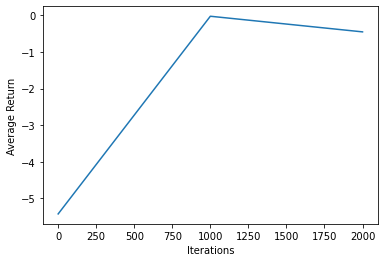

In [38]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')